In [1]:
import json
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader, Subset
from torch.nn.utils.rnn import pad_sequence
from transformers import GPT2Tokenizer, GPT2LMHeadModel, AdamW
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from nltk.translate.bleu_score import sentence_bleu
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
#readin training and test datas
file_path = 'qa_dataset.json'

with open(file_path, 'r') as file:
    data = json.load(file)

In [3]:
#prepare model
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token
model = GPT2LMHeadModel.from_pretrained('gpt2')
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [4]:
#customized dataset
class QADataset(Dataset):
    def __init__(self, tokenizer, data, block_size, train=True):
        self.train = True
        self.tokenizer = tokenizer
        self.questions_answers = []
        if not train:
            self.train = False
            self.answers = []

        with open(file_path, 'r') as file:
            for item in data:
                if train:
                    encoded = tokenizer.encode(f'Product: {item["product_name"]} Product Description: {item["product_description"]} Question: {item["question"]} Answer: {item["answer"]} {tokenizer.eos_token}', truncation=True, max_length=block_size, add_special_tokens=True)
                else:
                    encoded = tokenizer.encode(f'Product: {item["product_name"]} Product Description: {item["product_description"]} Question: {item["question"]}', truncation=True, max_length=block_size, add_special_tokens=False)
                    encoded2 = f'Product: {item["product_name"]} Product Description: {item["product_description"]} Question: {item["question"]} Answer: {item["answer"]}'
                    self.answers.append(encoded2)
                self.questions_answers.append(encoded)

    def __len__(self):
        return len(self.questions_answers)

    def __getitem__(self, idx):
        if self.train:
            return torch.tensor(self.questions_answers[idx], dtype=torch.long)
        else:
            return torch.tensor(self.questions_answers[idx], dtype=torch.long), self.answers[idx]

#padding functions
def collate_fn(batch):
    batch = pad_sequence(batch, batch_first=True, padding_value=tokenizer.pad_token_id)
    return batch
def collate_fn2(batch):
    questions, answers = zip(*batch)
    questions_tensor = [torch.tensor(question) for question in questions]
    max_len = max([q.size(0) for q in questions_tensor])
    questions_padded = torch.stack([torch.cat([torch.full((max_len - q.size(0),), tokenizer.pad_token_id), q]) for q in questions_tensor])
    attention_masks = torch.stack([torch.cat([torch.zeros(max_len - q.size(0)), torch.ones(q.size(0))]) for q in questions_tensor])
    return questions_padded, attention_masks, answers


In [5]:
#prepare data
train_size = round(len(data) * 0.7)
train_data = data[:train_size]
test_data = data[train_size:]
train_dataset = QADataset(tokenizer, train_data, 512)
test_dataset = QADataset(tokenizer, test_data, 512, train=False)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=3, shuffle=False, collate_fn=collate_fn2)

In [6]:
def prepare_model():
    #prepare model
    tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
    tokenizer.pad_token = tokenizer.eos_token
    model = GPT2LMHeadModel.from_pretrained('gpt2')
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.to(device)
    return model, tokenizer

In [7]:
def training(model, train_loader, epoch, optimizer, loss_fn):
    # #hyper parameters
    # epochs = 25
    
    # #optimizer
    # optimizer = AdamW(model.parameters(), lr=5e-5)
    
    # #loss function
    # loss_fn = torch.nn.CrossEntropyLoss()
    
    epoch_losses = []
    
    # Training loop
    model.train()
    for epoch in range(epoch):
        total_loss = 0
        for batch in tqdm(train_loader):
            inputs = batch.to(device)
            labels = batch.to(device)
            outputs = model(inputs, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        avg_loss = total_loss/len(train_loader)
        epoch_losses.append(avg_loss)
        print(f"Epoch {epoch+1} finished. Loss: {avg_loss}")
    return epoch_losses

In [8]:
def plot(epoch_losses, fold):
    # Plotting the training loss
    plt.plot(epoch_losses, label=f'Training Loss Fold {fold}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Training Loss Over Epochs Fold {fold}')
    plt.legend()
    plt.show()

In [9]:
def testing(model, test_loader):
    temp = tokenizer.padding_side
    tokenizer.padding_side = 'left'
    temp2 = model.config.pad_token_id
    model.config.pad_token_id = model.config.eos_token_id
    
    #switch to evaluation mode
    model.eval()
    
    #BLEU scores list
    bleu_scores = []
    
    for batch in tqdm(test_loader):
        encoded_questions, attention_masks, correct_answers = batch
        encoded_questions = encoded_questions.to(device)
        attention_masks = attention_masks.to(device)
        
        for i in range(encoded_questions.size(0)):
            with torch.no_grad():
                output = model.generate(encoded_questions[i].unsqueeze(0), 
                                        attention_mask=attention_masks[i].unsqueeze(0),
                                        max_length=512)  # Set `your_max_length` appropriately
                generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
                reference = correct_answers[i].split()
                candidate = generated_text.split()
    
                #calculate BLEU score
                score = sentence_bleu([reference], candidate)
                bleu_scores.append(score)
    
    #calculate average BLEU score across all items
    avg_bleu_score = sum(bleu_scores) / len(bleu_scores)
    return avg_bleu_score

### train 1

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
100%|██████████| 143/143 [00:30<00:00,  4.74it/s]


Epoch 1 finished. Loss: 1.960523667035403


100%|██████████| 143/143 [00:30<00:00,  4.75it/s]


Epoch 2 finished. Loss: 1.6094846967216971


100%|██████████| 143/143 [00:30<00:00,  4.70it/s]


Epoch 3 finished. Loss: 1.4206441332410265


100%|██████████| 143/143 [00:30<00:00,  4.72it/s]


Epoch 4 finished. Loss: 1.3019078303050329


100%|██████████| 143/143 [00:29<00:00,  4.82it/s]


Epoch 5 finished. Loss: 1.2042125307179832


100%|██████████| 143/143 [00:30<00:00,  4.71it/s]


Epoch 6 finished. Loss: 1.0515146670224784


100%|██████████| 143/143 [00:30<00:00,  4.71it/s]


Epoch 7 finished. Loss: 0.9550225530471002


100%|██████████| 143/143 [00:30<00:00,  4.72it/s]


Epoch 8 finished. Loss: 0.8883837494816813


100%|██████████| 143/143 [00:30<00:00,  4.74it/s]


Epoch 9 finished. Loss: 0.8168988807218058


100%|██████████| 143/143 [00:29<00:00,  4.84it/s]


Epoch 10 finished. Loss: 0.7826857250053566


100%|██████████| 143/143 [00:30<00:00,  4.70it/s]


Epoch 11 finished. Loss: 0.6897165504368868


100%|██████████| 143/143 [00:30<00:00,  4.75it/s]


Epoch 12 finished. Loss: 0.6546097068519859


100%|██████████| 143/143 [00:30<00:00,  4.61it/s]


Epoch 13 finished. Loss: 0.5818194957463058


100%|██████████| 143/143 [00:30<00:00,  4.73it/s]


Epoch 14 finished. Loss: 0.5621249040106794


100%|██████████| 143/143 [00:30<00:00,  4.70it/s]


Epoch 15 finished. Loss: 0.5069978041248722


100%|██████████| 143/143 [00:30<00:00,  4.70it/s]


Epoch 16 finished. Loss: 0.4780700669422016


100%|██████████| 143/143 [00:30<00:00,  4.68it/s]


Epoch 17 finished. Loss: 0.4454302687744994


100%|██████████| 143/143 [00:29<00:00,  4.77it/s]


Epoch 18 finished. Loss: 0.4198742780860487


100%|██████████| 143/143 [00:29<00:00,  4.80it/s]


Epoch 19 finished. Loss: 0.38826251415522783


100%|██████████| 143/143 [00:30<00:00,  4.73it/s]


Epoch 20 finished. Loss: 0.3530080235087788


100%|██████████| 143/143 [00:30<00:00,  4.68it/s]


Epoch 21 finished. Loss: 0.3277451203732224


100%|██████████| 143/143 [00:30<00:00,  4.72it/s]


Epoch 22 finished. Loss: 0.30443101454448035


100%|██████████| 143/143 [00:30<00:00,  4.69it/s]


Epoch 23 finished. Loss: 0.2831785871119766


100%|██████████| 143/143 [00:30<00:00,  4.66it/s]


Epoch 24 finished. Loss: 0.25819459323074434


100%|██████████| 143/143 [00:30<00:00,  4.66it/s]


Epoch 25 finished. Loss: 0.24041368260041818


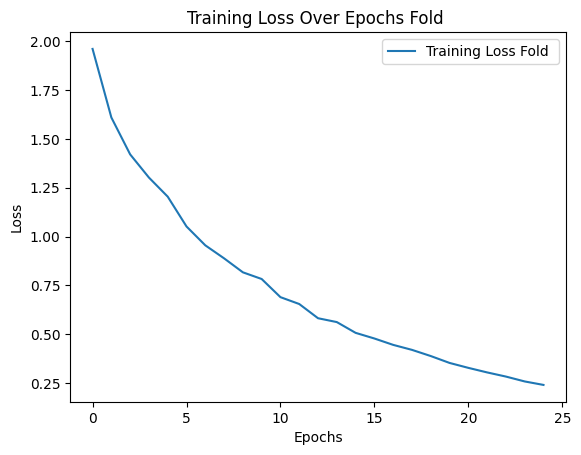

  0%|          | 0/163 [00:00<?, ?it/s]/tmp/ipykernel_4497/2159941939.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  questions_tensor = [torch.tensor(question) for question in questions]
/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1473: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(
 36%|███▌      | 58/163 [00:42<00:59,  1.76it/s]/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 512, but `max_length` is set to 512. 

Average BLEU Score: 0.7694795275655861


In [10]:
#hyper parameters
epochs = 25

#optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)

#loss function
loss_fn = torch.nn.CrossEntropyLoss()

epoch_losses = training(model, train_loader, epochs, optimizer, loss_fn)
plot(epoch_losses, "")
print(f"Average BLEU Score: {testing(model, test_loader)}")

In [12]:
#saving model
model.save_pretrained('./gpt2-qa-finetuned-25-epoch')

### K-fold

In [13]:
#k-fold (5)
kf = KFold(n_splits=5, shuffle=True)

FOLD 0
--------------------------------


100%|██████████| 163/163 [00:34<00:00,  4.69it/s]


Epoch 1 finished. Loss: 1.962772321847319


100%|██████████| 163/163 [00:34<00:00,  4.67it/s]


Epoch 2 finished. Loss: 1.6673412699640895


100%|██████████| 163/163 [00:35<00:00,  4.64it/s]


Epoch 3 finished. Loss: 1.5090033057277188


100%|██████████| 163/163 [00:34<00:00,  4.71it/s]


Epoch 4 finished. Loss: 1.3974525039912733


100%|██████████| 163/163 [00:34<00:00,  4.66it/s]


Epoch 5 finished. Loss: 1.2655578548191515


100%|██████████| 163/163 [00:34<00:00,  4.74it/s]


Epoch 6 finished. Loss: 1.190496369373579


100%|██████████| 163/163 [00:35<00:00,  4.63it/s]


Epoch 7 finished. Loss: 1.0596840699757535


100%|██████████| 163/163 [00:35<00:00,  4.66it/s]


Epoch 8 finished. Loss: 0.9756303842813691


100%|██████████| 163/163 [00:34<00:00,  4.70it/s]


Epoch 9 finished. Loss: 0.9013370054265473


100%|██████████| 163/163 [00:34<00:00,  4.66it/s]


Epoch 10 finished. Loss: 0.8295013685167932


100%|██████████| 163/163 [00:35<00:00,  4.63it/s]


Epoch 11 finished. Loss: 0.7679637805815854


100%|██████████| 163/163 [00:34<00:00,  4.72it/s]


Epoch 12 finished. Loss: 0.7230241209085734


100%|██████████| 163/163 [00:34<00:00,  4.68it/s]


Epoch 13 finished. Loss: 0.6692734031589485


100%|██████████| 163/163 [00:34<00:00,  4.67it/s]


Epoch 14 finished. Loss: 0.6161894111728375


100%|██████████| 163/163 [00:34<00:00,  4.68it/s]


Epoch 15 finished. Loss: 0.5807609735456712


100%|██████████| 163/163 [00:34<00:00,  4.67it/s]


Epoch 16 finished. Loss: 0.5323701787945683


100%|██████████| 163/163 [00:35<00:00,  4.59it/s]


Epoch 17 finished. Loss: 0.4902757881609209


100%|██████████| 163/163 [00:34<00:00,  4.71it/s]


Epoch 18 finished. Loss: 0.46913045333938364


100%|██████████| 163/163 [00:34<00:00,  4.72it/s]


Epoch 19 finished. Loss: 0.4369672167520582


100%|██████████| 163/163 [00:35<00:00,  4.66it/s]


Epoch 20 finished. Loss: 0.4006115843547634


100%|██████████| 163/163 [00:34<00:00,  4.67it/s]


Epoch 21 finished. Loss: 0.37479199423380427


100%|██████████| 163/163 [00:35<00:00,  4.64it/s]


Epoch 22 finished. Loss: 0.34421931984234444


100%|██████████| 163/163 [00:35<00:00,  4.61it/s]


Epoch 23 finished. Loss: 0.3174874689315726


100%|██████████| 163/163 [00:34<00:00,  4.70it/s]


Epoch 24 finished. Loss: 0.29819110118172654


100%|██████████| 163/163 [00:35<00:00,  4.62it/s]


Epoch 25 finished. Loss: 0.2742457759618028


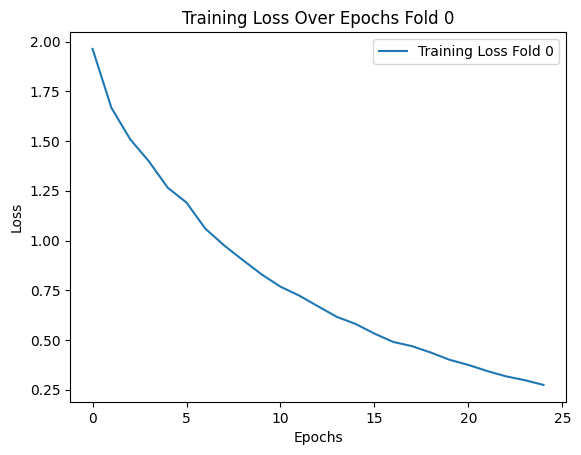

  0%|          | 0/109 [00:00<?, ?it/s]/tmp/ipykernel_4497/2159941939.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  questions_tensor = [torch.tensor(question) for question in questions]
/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1473: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(
  1%|          | 1/109 [00:00<00:34,  3.13it/s]/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 512, but `max_length` is set to 512. T

0.7627075450848558
FOLD 1
--------------------------------


100%|██████████| 163/163 [00:34<00:00,  4.79it/s]


Epoch 1 finished. Loss: 1.9247574733078845


100%|██████████| 163/163 [00:34<00:00,  4.76it/s]


Epoch 2 finished. Loss: 1.6167166265973285


100%|██████████| 163/163 [00:33<00:00,  4.85it/s]


Epoch 3 finished. Loss: 1.4879755911651564


100%|██████████| 163/163 [00:33<00:00,  4.83it/s]


Epoch 4 finished. Loss: 1.3435204303337753


100%|██████████| 163/163 [00:34<00:00,  4.79it/s]


Epoch 5 finished. Loss: 1.2225195085344138


100%|██████████| 163/163 [00:34<00:00,  4.70it/s]


Epoch 6 finished. Loss: 1.0814796424716528


100%|██████████| 163/163 [00:33<00:00,  4.84it/s]


Epoch 7 finished. Loss: 1.0290916655326914


100%|██████████| 163/163 [00:34<00:00,  4.75it/s]


Epoch 8 finished. Loss: 0.9254331756954545


100%|██████████| 163/163 [00:33<00:00,  4.94it/s]


Epoch 9 finished. Loss: 0.8856623366566524


100%|██████████| 163/163 [00:33<00:00,  4.82it/s]


Epoch 10 finished. Loss: 0.790663461560852


100%|██████████| 163/163 [00:34<00:00,  4.78it/s]


Epoch 11 finished. Loss: 0.736596767704911


100%|██████████| 163/163 [00:33<00:00,  4.82it/s]


Epoch 12 finished. Loss: 0.6837611026559139


100%|██████████| 163/163 [00:34<00:00,  4.78it/s]


Epoch 13 finished. Loss: 0.6330898571416644


100%|██████████| 163/163 [00:34<00:00,  4.74it/s]


Epoch 14 finished. Loss: 0.581268836567007


100%|██████████| 163/163 [00:34<00:00,  4.79it/s]


Epoch 15 finished. Loss: 0.5459446769002025


100%|██████████| 163/163 [00:33<00:00,  4.88it/s]


Epoch 16 finished. Loss: 0.5200554471622947


100%|██████████| 163/163 [00:33<00:00,  4.86it/s]


Epoch 17 finished. Loss: 0.4745201800315658


100%|██████████| 163/163 [00:34<00:00,  4.77it/s]


Epoch 18 finished. Loss: 0.43662342031492046


100%|██████████| 163/163 [00:33<00:00,  4.81it/s]


Epoch 19 finished. Loss: 0.4137213832578776


100%|██████████| 163/163 [00:33<00:00,  4.81it/s]


Epoch 20 finished. Loss: 0.3792520710295695


100%|██████████| 163/163 [00:33<00:00,  4.86it/s]


Epoch 21 finished. Loss: 0.3562086431161026


100%|██████████| 163/163 [00:34<00:00,  4.69it/s]


Epoch 22 finished. Loss: 0.31396194012618506


100%|██████████| 163/163 [00:34<00:00,  4.76it/s]


Epoch 23 finished. Loss: 0.29825470404573745


100%|██████████| 163/163 [00:34<00:00,  4.75it/s]


Epoch 24 finished. Loss: 0.27491589023108864


100%|██████████| 163/163 [00:33<00:00,  4.81it/s]

Epoch 25 finished. Loss: 0.2604623007719502


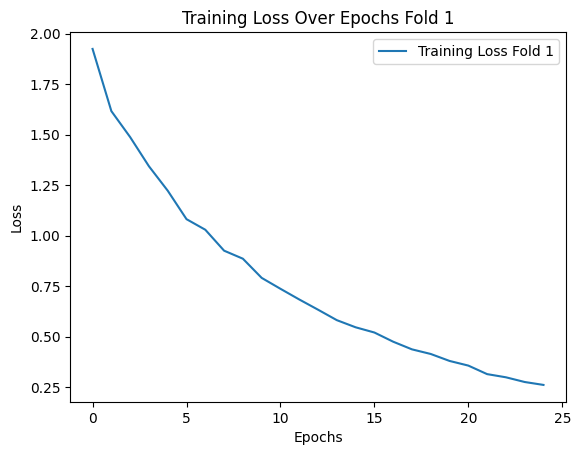

100%|██████████| 109/109 [01:13<00:00,  1.48it/s]


0.7622495034030937
FOLD 2
--------------------------------


100%|██████████| 163/163 [00:34<00:00,  4.77it/s]


Epoch 1 finished. Loss: 1.9612492366802472


100%|██████████| 163/163 [00:34<00:00,  4.78it/s]


Epoch 2 finished. Loss: 1.6852926904438463


100%|██████████| 163/163 [00:34<00:00,  4.66it/s]


Epoch 3 finished. Loss: 1.4935969066766142


100%|██████████| 163/163 [00:34<00:00,  4.73it/s]


Epoch 4 finished. Loss: 1.3674418055938065


100%|██████████| 163/163 [00:34<00:00,  4.73it/s]


Epoch 5 finished. Loss: 1.24012509957413


100%|██████████| 163/163 [00:35<00:00,  4.63it/s]


Epoch 6 finished. Loss: 1.1080209444636948


100%|██████████| 163/163 [00:33<00:00,  4.84it/s]


Epoch 7 finished. Loss: 1.06699178226155


100%|██████████| 163/163 [00:33<00:00,  4.85it/s]


Epoch 8 finished. Loss: 0.9722887460439483


100%|██████████| 163/163 [00:34<00:00,  4.68it/s]


Epoch 9 finished. Loss: 0.8687006006577264


100%|██████████| 163/163 [00:34<00:00,  4.76it/s]


Epoch 10 finished. Loss: 0.8122461013998722


100%|██████████| 163/163 [00:35<00:00,  4.60it/s]


Epoch 11 finished. Loss: 0.7187533780841008


100%|██████████| 163/163 [00:35<00:00,  4.62it/s]


Epoch 12 finished. Loss: 0.6848649394475609


100%|██████████| 163/163 [00:33<00:00,  4.86it/s]


Epoch 13 finished. Loss: 0.6738029996310275


100%|██████████| 163/163 [00:34<00:00,  4.72it/s]


Epoch 14 finished. Loss: 0.6033906178788905


100%|██████████| 163/163 [00:34<00:00,  4.68it/s]


Epoch 15 finished. Loss: 0.5528331082657071


100%|██████████| 163/163 [00:34<00:00,  4.67it/s]


Epoch 16 finished. Loss: 0.5143096274210631


100%|██████████| 163/163 [00:34<00:00,  4.73it/s]


Epoch 17 finished. Loss: 0.4931006213090171


100%|██████████| 163/163 [00:35<00:00,  4.63it/s]


Epoch 18 finished. Loss: 0.4418070019205655


100%|██████████| 163/163 [00:34<00:00,  4.69it/s]


Epoch 19 finished. Loss: 0.4116833491559409


100%|██████████| 163/163 [00:34<00:00,  4.69it/s]


Epoch 20 finished. Loss: 0.38932012762028745


100%|██████████| 163/163 [00:35<00:00,  4.62it/s]


Epoch 21 finished. Loss: 0.3538892978996587


100%|██████████| 163/163 [00:34<00:00,  4.70it/s]


Epoch 22 finished. Loss: 0.3350641159740694


100%|██████████| 163/163 [00:34<00:00,  4.73it/s]


Epoch 23 finished. Loss: 0.3147313226402903


100%|██████████| 163/163 [00:34<00:00,  4.74it/s]


Epoch 24 finished. Loss: 0.2915461742621989


100%|██████████| 163/163 [00:34<00:00,  4.78it/s]


Epoch 25 finished. Loss: 0.2725340826836832


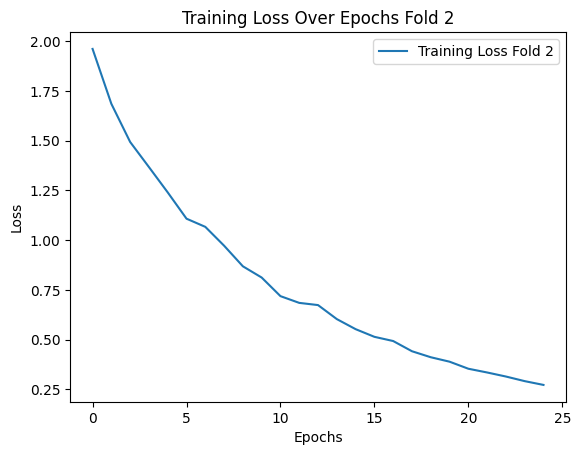

100%|██████████| 109/109 [01:17<00:00,  1.40it/s]


0.7547937106749399
FOLD 3
--------------------------------


100%|██████████| 163/163 [00:33<00:00,  4.81it/s]


Epoch 1 finished. Loss: 1.9813510252654187


100%|██████████| 163/163 [00:34<00:00,  4.70it/s]


Epoch 2 finished. Loss: 1.6418546061574315


100%|██████████| 163/163 [00:34<00:00,  4.70it/s]


Epoch 3 finished. Loss: 1.5021862808180733


100%|██████████| 163/163 [00:34<00:00,  4.77it/s]


Epoch 4 finished. Loss: 1.3841745235437264


100%|██████████| 163/163 [00:34<00:00,  4.68it/s]


Epoch 5 finished. Loss: 1.2426565124944675


100%|██████████| 163/163 [00:34<00:00,  4.70it/s]


Epoch 6 finished. Loss: 1.1268763139935358


100%|██████████| 163/163 [00:36<00:00,  4.52it/s]


Epoch 7 finished. Loss: 0.9946367495630416


100%|██████████| 163/163 [00:34<00:00,  4.70it/s]


Epoch 8 finished. Loss: 0.9493829320910518


100%|██████████| 163/163 [00:34<00:00,  4.66it/s]


Epoch 9 finished. Loss: 0.8687753743189244


100%|██████████| 163/163 [00:34<00:00,  4.73it/s]


Epoch 10 finished. Loss: 0.8147556964605133


100%|██████████| 163/163 [00:34<00:00,  4.76it/s]


Epoch 11 finished. Loss: 0.7570325542081353


100%|██████████| 163/163 [00:34<00:00,  4.75it/s]


Epoch 12 finished. Loss: 0.707461381068259


100%|██████████| 163/163 [00:34<00:00,  4.71it/s]


Epoch 13 finished. Loss: 0.6531850600535153


100%|██████████| 163/163 [00:35<00:00,  4.65it/s]


Epoch 14 finished. Loss: 0.5960022175421744


100%|██████████| 163/163 [00:34<00:00,  4.67it/s]


Epoch 15 finished. Loss: 0.5566878768564002


100%|██████████| 163/163 [00:33<00:00,  4.83it/s]


Epoch 16 finished. Loss: 0.543259826723052


100%|██████████| 163/163 [00:34<00:00,  4.76it/s]


Epoch 17 finished. Loss: 0.49088956525355026


100%|██████████| 163/163 [00:34<00:00,  4.78it/s]


Epoch 18 finished. Loss: 0.4572120864698492


100%|██████████| 163/163 [00:34<00:00,  4.71it/s]


Epoch 19 finished. Loss: 0.4182298421128396


100%|██████████| 163/163 [00:34<00:00,  4.67it/s]


Epoch 20 finished. Loss: 0.3831688466430442


100%|██████████| 163/163 [00:34<00:00,  4.79it/s]


Epoch 21 finished. Loss: 0.3687123081252619


100%|██████████| 163/163 [00:34<00:00,  4.68it/s]


Epoch 22 finished. Loss: 0.32912228114765846


100%|██████████| 163/163 [00:35<00:00,  4.60it/s]


Epoch 23 finished. Loss: 0.30056115765513086


100%|██████████| 163/163 [00:35<00:00,  4.64it/s]


Epoch 24 finished. Loss: 0.28312261457457866


100%|██████████| 163/163 [00:34<00:00,  4.71it/s]


Epoch 25 finished. Loss: 0.26633933136251076


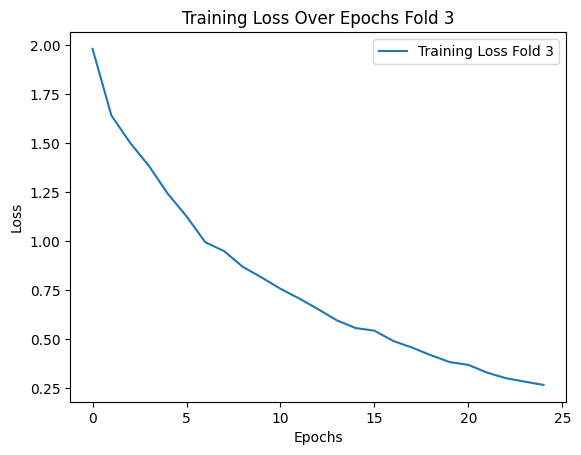

100%|██████████| 109/109 [01:14<00:00,  1.47it/s]


0.7485971929287031
FOLD 4
--------------------------------


100%|██████████| 163/163 [00:33<00:00,  4.84it/s]


Epoch 1 finished. Loss: 1.9599245954876297


100%|██████████| 163/163 [00:33<00:00,  4.84it/s]


Epoch 2 finished. Loss: 1.667292532379642


100%|██████████| 163/163 [00:34<00:00,  4.75it/s]


Epoch 3 finished. Loss: 1.5075425030263656


100%|██████████| 163/163 [00:34<00:00,  4.71it/s]


Epoch 4 finished. Loss: 1.3545284958704848


100%|██████████| 163/163 [00:34<00:00,  4.79it/s]


Epoch 5 finished. Loss: 1.2534469501372496


100%|██████████| 163/163 [00:33<00:00,  4.80it/s]


Epoch 6 finished. Loss: 1.1455219205171785


100%|██████████| 163/163 [00:34<00:00,  4.79it/s]


Epoch 7 finished. Loss: 1.0408177083255323


100%|██████████| 163/163 [00:34<00:00,  4.71it/s]


Epoch 8 finished. Loss: 0.93676740059092


100%|██████████| 163/163 [00:33<00:00,  4.80it/s]


Epoch 9 finished. Loss: 0.8900871796110656


100%|██████████| 163/163 [00:34<00:00,  4.75it/s]


Epoch 10 finished. Loss: 0.80906338523502


100%|██████████| 163/163 [00:34<00:00,  4.74it/s]


Epoch 11 finished. Loss: 0.7524604927177078


100%|██████████| 163/163 [00:34<00:00,  4.72it/s]


Epoch 12 finished. Loss: 0.6980214290823673


100%|██████████| 163/163 [00:34<00:00,  4.72it/s]


Epoch 13 finished. Loss: 0.6372575420726296


100%|██████████| 163/163 [00:33<00:00,  4.80it/s]


Epoch 14 finished. Loss: 0.6058796374527223


100%|██████████| 163/163 [00:33<00:00,  4.82it/s]


Epoch 15 finished. Loss: 0.5638892455883553


100%|██████████| 163/163 [00:34<00:00,  4.75it/s]


Epoch 16 finished. Loss: 0.5180918279966694


100%|██████████| 163/163 [00:34<00:00,  4.68it/s]


Epoch 17 finished. Loss: 0.4731918999388174


100%|██████████| 163/163 [00:33<00:00,  4.82it/s]


Epoch 18 finished. Loss: 0.45665222808627265


100%|██████████| 163/163 [00:33<00:00,  4.87it/s]


Epoch 19 finished. Loss: 0.4265571528234365


100%|██████████| 163/163 [00:34<00:00,  4.75it/s]


Epoch 20 finished. Loss: 0.38824175700453895


100%|██████████| 163/163 [00:34<00:00,  4.79it/s]


Epoch 21 finished. Loss: 0.3602847849116004


100%|██████████| 163/163 [00:34<00:00,  4.74it/s]


Epoch 22 finished. Loss: 0.3329374272764826


100%|██████████| 163/163 [00:34<00:00,  4.70it/s]


Epoch 23 finished. Loss: 0.3087528429331224


100%|██████████| 163/163 [00:34<00:00,  4.67it/s]


Epoch 24 finished. Loss: 0.2794053222229876


100%|██████████| 163/163 [00:34<00:00,  4.71it/s]


Epoch 25 finished. Loss: 0.26609503939473556


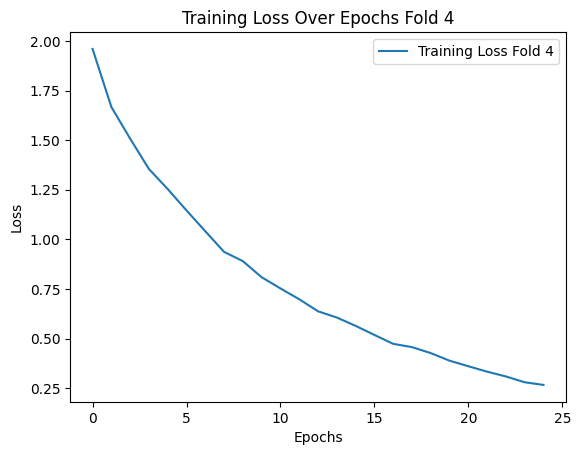

100%|██████████| 109/109 [00:55<00:00,  1.98it/s]

0.7781408692982921


In [15]:
for fold, (train_ids, test_ids) in enumerate(kf.split(data)):
    print(f'FOLD {fold}')
    print('--------------------------------')
    model, tokenizer = prepare_model()
    
    train_data = [data[i] for i in train_ids]
    test_data = [data[i] for i in test_ids]
    #create datasets for this fold
    train_dataset = QADataset(tokenizer, train_data, 512)
    test_dataset = QADataset(tokenizer, test_data, 512, train=False)

    #creating data loaders for each fold
    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)
    test_loader = DataLoader(test_dataset, batch_size=3, shuffle=False, collate_fn=collate_fn2)

    epoch_losses = training(model, train_loader, 25, AdamW(model.parameters(), lr=5e-5), torch.nn.CrossEntropyLoss())
    plot(epoch_losses, fold)
    print(testing(model, test_loader))

### Train 2

100%|██████████| 285/285 [00:27<00:00, 10.30it/s]


Epoch 1 finished. Loss: 2.539600878431086


100%|██████████| 285/285 [00:27<00:00, 10.33it/s]


Epoch 2 finished. Loss: 2.2373200905950448


100%|██████████| 285/285 [00:27<00:00, 10.25it/s]


Epoch 3 finished. Loss: 2.0876929797624286


100%|██████████| 285/285 [00:27<00:00, 10.26it/s]


Epoch 4 finished. Loss: 1.9975944487672104


100%|██████████| 285/285 [00:27<00:00, 10.29it/s]


Epoch 5 finished. Loss: 1.9329794737330654


100%|██████████| 285/285 [00:28<00:00, 10.14it/s]


Epoch 6 finished. Loss: 1.8199388794731675


100%|██████████| 285/285 [00:27<00:00, 10.38it/s]


Epoch 7 finished. Loss: 1.7882543731154057


100%|██████████| 285/285 [00:27<00:00, 10.23it/s]


Epoch 8 finished. Loss: 1.7033699577314811


100%|██████████| 285/285 [00:28<00:00, 10.11it/s]


Epoch 9 finished. Loss: 1.6209382931391398


100%|██████████| 285/285 [00:27<00:00, 10.23it/s]


Epoch 10 finished. Loss: 1.560655427188204


100%|██████████| 285/285 [00:28<00:00, 10.13it/s]


Epoch 11 finished. Loss: 1.5024411295589648


100%|██████████| 285/285 [00:27<00:00, 10.23it/s]


Epoch 12 finished. Loss: 1.4641715221237719


100%|██████████| 285/285 [00:28<00:00, 10.14it/s]


Epoch 13 finished. Loss: 1.403002909819285


100%|██████████| 285/285 [00:28<00:00, 10.15it/s]


Epoch 14 finished. Loss: 1.3404974788950201


100%|██████████| 285/285 [00:27<00:00, 10.26it/s]


Epoch 15 finished. Loss: 1.3135936106506148


100%|██████████| 285/285 [00:49<00:00,  5.75it/s]


Epoch 16 finished. Loss: 1.2930269402370118


100%|██████████| 285/285 [00:55<00:00,  5.13it/s]


Epoch 17 finished. Loss: 1.2363397338934112


100%|██████████| 285/285 [00:27<00:00, 10.32it/s]


Epoch 18 finished. Loss: 1.2108075679394237


100%|██████████| 285/285 [00:28<00:00, 10.16it/s]


Epoch 19 finished. Loss: 1.1469144981158408


100%|██████████| 285/285 [00:27<00:00, 10.27it/s]


Epoch 20 finished. Loss: 1.1297985467994422


100%|██████████| 285/285 [00:28<00:00, 10.15it/s]


Epoch 21 finished. Loss: 1.0803633635504204


100%|██████████| 285/285 [00:27<00:00, 10.31it/s]


Epoch 22 finished. Loss: 1.0849692697064919


100%|██████████| 285/285 [00:28<00:00, 10.15it/s]


Epoch 23 finished. Loss: 1.0343330111419946


100%|██████████| 285/285 [00:28<00:00, 10.14it/s]


Epoch 24 finished. Loss: 0.9900955530635097


100%|██████████| 285/285 [00:28<00:00, 10.15it/s]


Epoch 25 finished. Loss: 0.9685286351463251


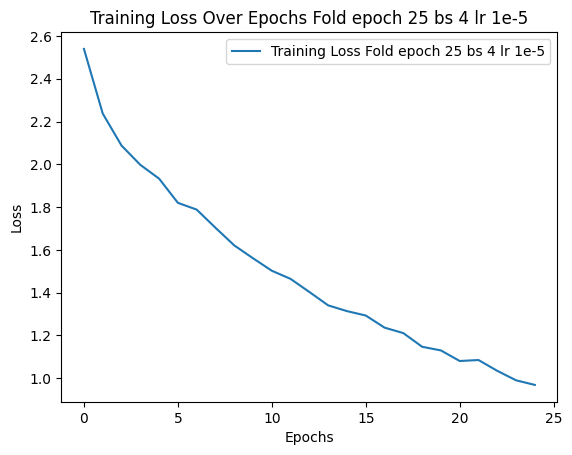

  0%|          | 0/163 [00:00<?, ?it/s]/tmp/ipykernel_4497/2159941939.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  questions_tensor = [torch.tensor(question) for question in questions]
100%|██████████| 163/163 [01:17<00:00,  2.12it/s]

Average BLEU Score: 0.7922211407271589


In [16]:
model, tokenizer = prepare_model()
#prepare data
train_size = round(len(data) * 0.7)
train_data = data[:train_size]
test_data = data[train_size:]
train_dataset = QADataset(tokenizer, train_data, 512)
test_dataset = QADataset(tokenizer, test_data, 512, train=False)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=3, shuffle=False, collate_fn=collate_fn2)

#hyper parameters
epochs = 25

#optimizer
optimizer = AdamW(model.parameters(), lr=1e-5)

#loss function
loss_fn = torch.nn.CrossEntropyLoss()

epoch_losses = training(model, train_loader, epochs, optimizer, loss_fn)
plot(epoch_losses, "epoch 25 bs 4 lr 1e-5")
print(f"Average BLEU Score: {testing(model, test_loader)}")

### Train 3

In [ ]:
model, tokenizer = prepare_model()
#prepare data
train_size = round(len(data) * 0.7)
train_data = data[:train_size]
test_data = data[train_size:]
train_dataset = QADataset(tokenizer, train_data, 512)
test_dataset = QADataset(tokenizer, test_data, 512, train=False)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=3, shuffle=False, collate_fn=collate_fn2)

#hyper parameters
epochs = 25

#optimizer
optimizer = AdamW(model.parameters(), lr=1e-5)

#loss function
loss_fn = torch.nn.CrossEntropyLoss()

epoch_losses = training(model, train_loader, epochs, optimizer, loss_fn)
plot(epoch_losses, "epoch 25 bs 8 lr 1e-5")
print(f"Average BLEU Score: {testing(model, test_loader)}")

100%|██████████| 143/143 [00:29<00:00,  4.81it/s]


Epoch 1 finished. Loss: 2.2449033960595832


100%|██████████| 143/143 [00:29<00:00,  4.81it/s]


Epoch 2 finished. Loss: 1.89353404178486


100%|██████████| 143/143 [00:29<00:00,  4.83it/s]


Epoch 3 finished. Loss: 1.8282824046128279


100%|██████████| 143/143 [00:30<00:00,  4.76it/s]


Epoch 4 finished. Loss: 1.7336388476245053


100%|██████████| 143/143 [00:29<00:00,  4.91it/s]


Epoch 5 finished. Loss: 1.720850709851805


100%|██████████| 143/143 [00:29<00:00,  4.79it/s]


Epoch 6 finished. Loss: 1.6324855951996116


 33%|███▎      | 47/143 [00:09<00:15,  6.14it/s]

### Train 4

In [ ]:
model, tokenizer = prepare_model()
#prepare data
train_size = round(len(data) * 0.7)
train_data = data[:train_size]
test_data = data[train_size:]
train_dataset = QADataset(tokenizer, train_data, 512)
test_dataset = QADataset(tokenizer, test_data, 512, train=False)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=3, shuffle=False, collate_fn=collate_fn2)

#hyper parameters
epochs = 25

#optimizer
optimizer = AdamW(model.parameters(), lr=1e-4)

#loss function
loss_fn = torch.nn.CrossEntropyLoss()

epoch_losses = training(model, train_loader, epochs, optimizer, loss_fn)
plot(epoch_losses, "epoch 25 bs 4 lr 1e-4")
print(f"Average BLEU Score: {testing(model, test_loader)}")

### Train 5

In [ ]:
model, tokenizer = prepare_model()
#prepare data
train_size = round(len(data) * 0.7)
train_data = data[:train_size]
test_data = data[train_size:]
train_dataset = QADataset(tokenizer, train_data, 512)
test_dataset = QADataset(tokenizer, test_data, 512, train=False)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=3, shuffle=False, collate_fn=collate_fn2)

#hyper parameters
epochs = 25

#optimizer
optimizer = AdamW(model.parameters(), lr=1e-4)

#loss function
loss_fn = torch.nn.CrossEntropyLoss()

epoch_losses = training(model, train_loader, epochs, optimizer, loss_fn)
plot(epoch_losses, "epoch 25 bs 8 lr 1e-4")
print(f"Average BLEU Score: {testing(model, test_loader)}")

### Train 6

In [ ]:
model, tokenizer = prepare_model()
#prepare data
train_size = round(len(data) * 0.7)
train_data = data[:train_size]
test_data = data[train_size:]
train_dataset = QADataset(tokenizer, train_data, 512)
test_dataset = QADataset(tokenizer, test_data, 512, train=False)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=3, shuffle=False, collate_fn=collate_fn2)

#hyper parameters
epochs = 30

#optimizer
optimizer = AdamW(model.parameters(), lr=1e-5)

#loss function
loss_fn = torch.nn.CrossEntropyLoss()

epoch_losses = training(model, train_loader, epochs, optimizer, loss_fn)
plot(epoch_losses, "epoch 30 bs 4 lr 1e-5")
print(f"Average BLEU Score: {testing(model, test_loader)}")

### Train 7

In [ ]:
model, tokenizer = prepare_model()
#prepare data
train_size = round(len(data) * 0.7)
train_data = data[:train_size]
test_data = data[train_size:]
train_dataset = QADataset(tokenizer, train_data, 512)
test_dataset = QADataset(tokenizer, test_data, 512, train=False)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=3, shuffle=False, collate_fn=collate_fn2)

#hyper parameters
epochs = 30

#optimizer
optimizer = AdamW(model.parameters(), lr=1e-5)

#loss function
loss_fn = torch.nn.CrossEntropyLoss()

epoch_losses = training(model, train_loader, epochs, optimizer, loss_fn)
plot(epoch_losses, "epoch 30 bs 8 lr 1e-5")
print(f"Average BLEU Score: {testing(model, test_loader)}")

### Train 8

In [ ]:
model, tokenizer = prepare_model()
#prepare data
train_size = round(len(data) * 0.7)
train_data = data[:train_size]
test_data = data[train_size:]
train_dataset = QADataset(tokenizer, train_data, 512)
test_dataset = QADataset(tokenizer, test_data, 512, train=False)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=3, shuffle=False, collate_fn=collate_fn2)

#hyper parameters
epochs = 30

#optimizer
optimizer = AdamW(model.parameters(), lr=1e-4)

#loss function
loss_fn = torch.nn.CrossEntropyLoss()

epoch_losses = training(model, train_loader, epochs, optimizer, loss_fn)
plot(epoch_losses, "epoch 30 bs 4 lr 1e-4")
print(f"Average BLEU Score: {testing(model, test_loader)}")

### Train 9

In [ ]:
model, tokenizer = prepare_model()
#prepare data
train_size = round(len(data) * 0.7)
train_data = data[:train_size]
test_data = data[train_size:]
train_dataset = QADataset(tokenizer, train_data, 512)
test_dataset = QADataset(tokenizer, test_data, 512, train=False)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=3, shuffle=False, collate_fn=collate_fn2)

#hyper parameters
epochs = 30

#optimizer
optimizer = AdamW(model.parameters(), lr=1e-4)

#loss function
loss_fn = torch.nn.CrossEntropyLoss()

epoch_losses = training(model, train_loader, epochs, optimizer, loss_fn)
plot(epoch_losses, "epoch 80 bs 30 lr 1e-4")
print(f"Average BLEU Score: {testing(model, test_loader)}")

### Train 10

In [ ]:
model, tokenizer = prepare_model()
#prepare data
train_size = round(len(data) * 0.7)
train_data = data[:train_size]
test_data = data[train_size:]
train_dataset = QADataset(tokenizer, train_data, 512)
test_dataset = QADataset(tokenizer, test_data, 512, train=False)
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=3, shuffle=False, collate_fn=collate_fn2)

#hyper parameters
epochs = 25

#optimizer
optimizer = AdamW(model.parameters(), lr=1e-6)

#loss function
loss_fn = torch.nn.CrossEntropyLoss()

epoch_losses = training(model, train_loader, epochs, optimizer, loss_fn)
plot(epoch_losses, "epoch 25 bs 2 lr 1e-6")
print(f"Average BLEU Score: {testing(model, test_loader)}")